# First test of PatternLearner network on Fugues Data

In [1]:
import os
from time import time
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

from Fugues_data.loader import FuguesDataset
from ML.architecture import PatternLearner, CorrelationLoss
from ripdalib.variations.plot import plot_matrix, plot_correlation, plot_patterns_from_correlation

In [2]:
DATA_PATH = os.path.join("Fugues_data", "data_8_reduced.pkl")
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.2
CNN_MODEL_NAME = 'cnn_patterns_'
MINDIV = 8 #from Fugues_data.midi_to_pkl import MINDIV

CONV_BIASES = False
BATCHNORM_AFFINE = False
DENSE_BIAS = False

MAX_EPOCH = 200
BATCH_SIZE = 10
LEARNING_RATE = 0.1
EPSILON = 0.0000001
PATTERNS_MAXSIZE = (1, 4*8, 13)
PATIENCE = 3
REFINEMENT = 3  # restart training after patience runs out with the best model, decrease lr by...
LR_FAC = 0.1    # ... the learning rate factor lr_fac: lr_new = lr_old*lr_fac
LOG_INTERVAL = 60  # seconds

SEED = 689

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the dataset

In [3]:
data = FuguesDataset(DATA_PATH, mindiv=MINDIV)
print(data[:].shape)

torch.manual_seed(SEED)
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 0}
train, test_data = random_split(data, [(1-TEST_SIZE), TEST_SIZE])
train, validation = random_split(train, [(1-VALIDATION_SIZE), VALIDATION_SIZE])
valid_data = next(iter(DataLoader(validation, len(validation), **kwargs))).float().to(device)
train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, **kwargs)
test_data = next(iter(DataLoader(test_data, len(test_data), **kwargs))).float().to(device)

torch.Size([192, 1, 3856, 60])


Each music file is nearly equivalent to a picture of size 1000x500.

In [4]:
print(next(iter(train_loader)).shape, data[0].shape)

torch.Size([10, 1, 3856, 60]) torch.Size([1, 3856, 60])


## Load architecture

In [5]:
model = PatternLearner(data[0].shape, PATTERNS_MAXSIZE, biases_conv=CONV_BIASES, bias_dense=DENSE_BIAS, learnable_batch_norm=BATCHNORM_AFFINE).to(device)

test = torch.rand((2, *data[0].shape))
print(model(test, True).shape)

Shape after conv 1 : torch.Size([2, 2, 642, 60])
Shape after conv 2 : torch.Size([2, 4, 107, 60])
Shape after conv 3 : torch.Size([2, 8, 17, 60])
Shape after conv 4 : torch.Size([2, 16, 2, 6])
Shape after dense Layer : torch.Size([2, 416])
torch.Size([2, 1, 32, 13])


In [6]:
total_params = 0
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name)
        print(p.numel())
        total_params += p.numel()
print(f"Number of parameters: {total_params}")

boost
1
conv1.weight
234
conv2.weight
936
conv3.weight
3744
conv4.weight
14976
dense5.weight
79872
Number of parameters: 99763


## Train functions

In [7]:
OPTIMIZER = Adam
LOSS_FUNCTION = CorrelationLoss().minmax_regul(beta=0.1)

In [8]:
def train_epoch_cnn(model, optimizer, train_loader):
    """
    Training loop for one epoch of NN training.
    """
    model.train()  # set model to training mode (activate dropout layers if any)
    t = time() # we measure the needed time
    for batch_idx, input_data in enumerate(train_loader):  # iterate over training input_data
        input_data = input_data.float().to(device)  # move input_data to device (GPU) if necessary
        optimizer.zero_grad()  # reset optimizer
        output = model(input_data)   # forward pass: calculate output of network for input_data
        loss = LOSS_FUNCTION(output, input_data)

        loss.backward()  # backward pass: calculate gradients using automatic diff. and backprop.
        optimizer.step()  # udpate parameters of network using our optimizer
        cur_time = time()
        # print some outputs if we reached our logging interval
        if cur_time - t > LOG_INTERVAL or batch_idx == len(train_loader)-1:  
            print(f"[{batch_idx * BATCH_SIZE}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]",
                  f"\tloss: {loss.item():.6f}, took {cur_time - t:.2f}s")
            t = cur_time


def valid_cnn(model, test_data):
    """
    Test loss evaluation
    """
    model.eval()  # set model to inference mode (deactivate dropout layers)
    with torch.no_grad():  # do not calculate gradients since we do not want to do updates
        output = model(test_data)
        loss = LOSS_FUNCTION(output, test_data)
    print(f'Average eval loss: {loss:.4f}\n')
    return loss

In [9]:
def train_cnn():
    """
    Run CNN training using the datasets.

    Return
    ------
        nn.Model
            trained model
    """
    global model, train_loader, valid_data, test_data

    # create model and optimizer, we use plain SGD with momentum
    optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE)

    model_cnt = 0
    new_model_file = os.path.join(CNN_MODEL_NAME + str(model_cnt) + '.model')
    while os.path.exists(new_model_file):
        model_cnt += 1
        new_model_file = os.path.join(CNN_MODEL_NAME + str(model_cnt) + '.model')
    

    # train model for max_epochs epochs, output loss after log_intervall seconds.
    # for each epoch run once on validation set, 
    # write model to disk if validation loss decreased
    # if validation loss increased, check for early stopping with patience and refinements
    # after model is trained, perform a run on test set and output loss (don't forget to reload best model!)
    best_valid_loss = 9999.
    cur_patience = PATIENCE
    cur_refin = REFINEMENT

    #model.load_state_dict(torch.load(last_model_file, map_location=device).state_dict())
    print('Training CNN...')
    start_t = time()

    for epoch in range(1, MAX_EPOCH+1):
        train_epoch_cnn(model, optimizer, train_loader)
        valid_loss = valid_cnn(model, valid_data)

        if valid_loss < best_valid_loss:
            torch.save(model, new_model_file)
            best_valid_loss = valid_loss
            cur_patience = PATIENCE

        elif cur_patience <=0:
            model = torch.load(new_model_file, map_location=device, weights_only=False)
            if cur_refin <= 0:
                print("Max refinement reached !")
                break
            else:
                print("Max patience reached !")
                
                cur_patience = PATIENCE
                for param_group in optimizer.param_groups:
                    lr = LR_FAC * param_group['lr']
                    param_group['lr'] = lr
                cur_refin -= 1
            
        else:
            print("We still have patience...")
            cur_patience -= 1
    
    print(f'Training took: {time()-start_t:.2f}s for {epoch} epochs')
    print(f"Final Test loss : {valid_cnn(model, test_data):.6f}")
    
    return model



def load_cnn(load_model:str):
    "Load the model."
    if load_model is None or not os.path.exists(load_model):
        print('Model file not found, unable to load...')
    else:
        model = torch.load(load_model, map_location=device)
        print("Model file loaded: {}".format(load_model))
    return model

In [ ]:
#train_cnn()

## Test our network

In [10]:
model = load_cnn("cnn_patterns_3.model")

Model file loaded: cnn_patterns_3.model


In [11]:
for name, p in model.named_parameters():
    print(name)
    print(p.numel())

boost
1
conv1.weight
234
batchnorm1.weight
2
batchnorm1.bias
2
conv2.weight
936
batchnorm2.weight
4
batchnorm2.bias
4
conv3.weight
3744
batchnorm3.weight
8
batchnorm3.bias
8
conv4.weight
14976
batchnorm4.weight
16
batchnorm4.bias
16
dense5.weight
79872


torch.Size([10, 1, 3856, 60])
torch.Size([10, 1, 32, 13])


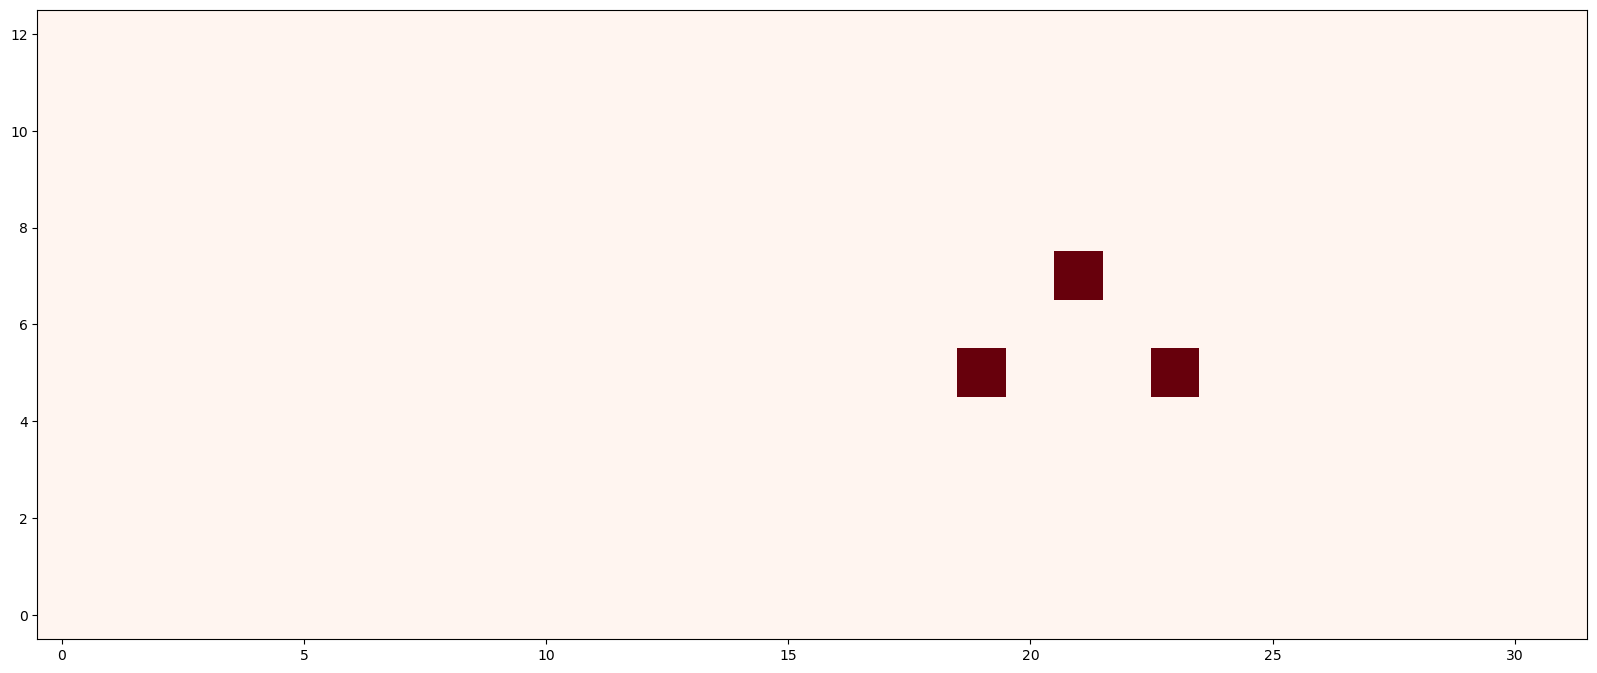

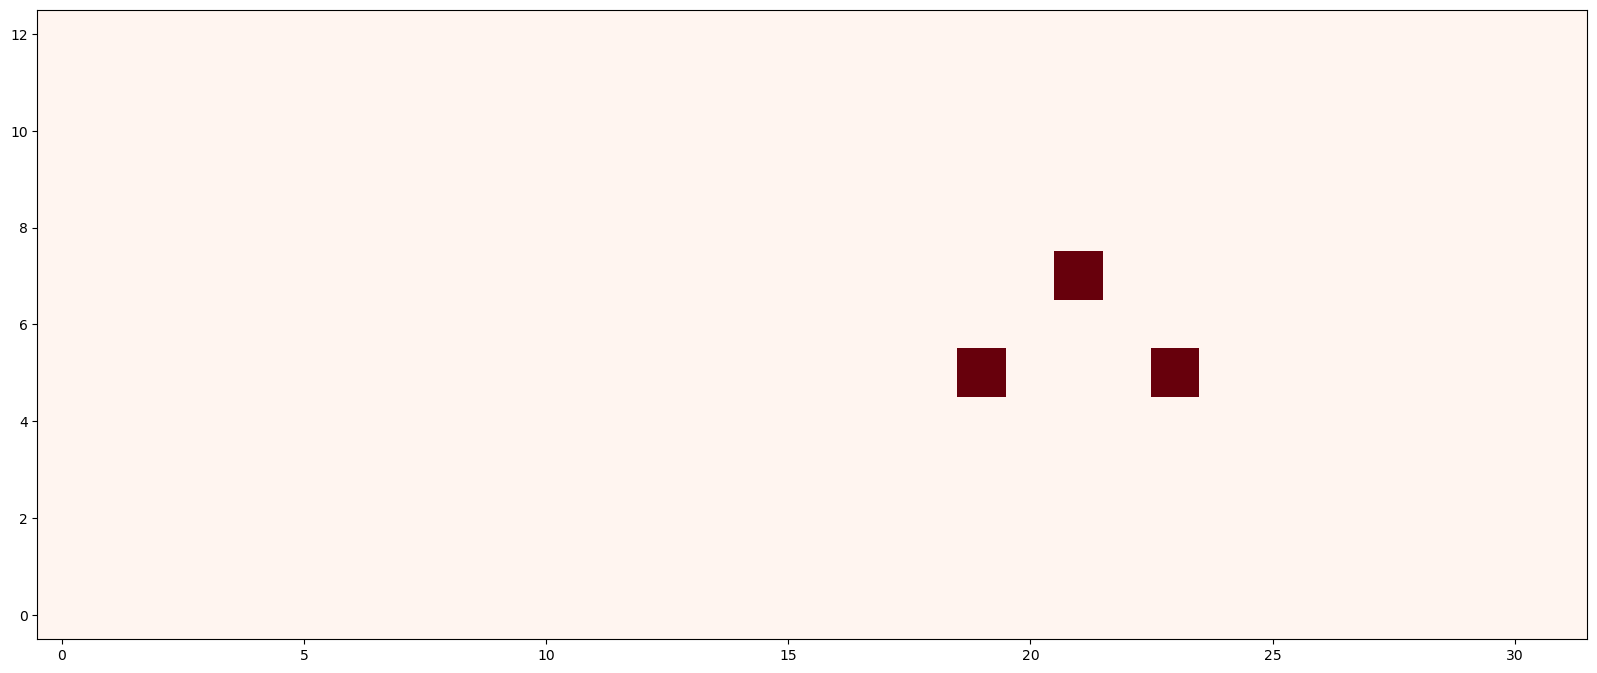

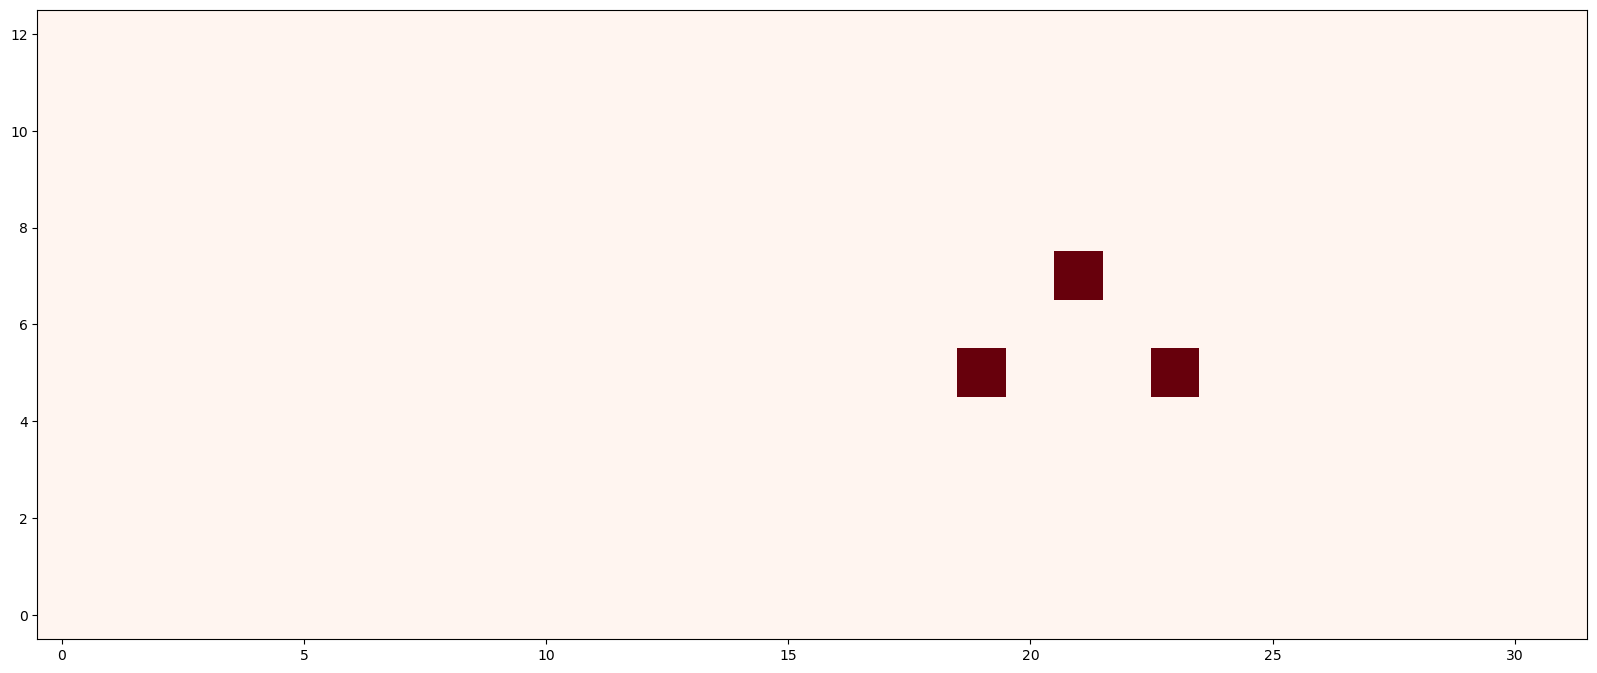

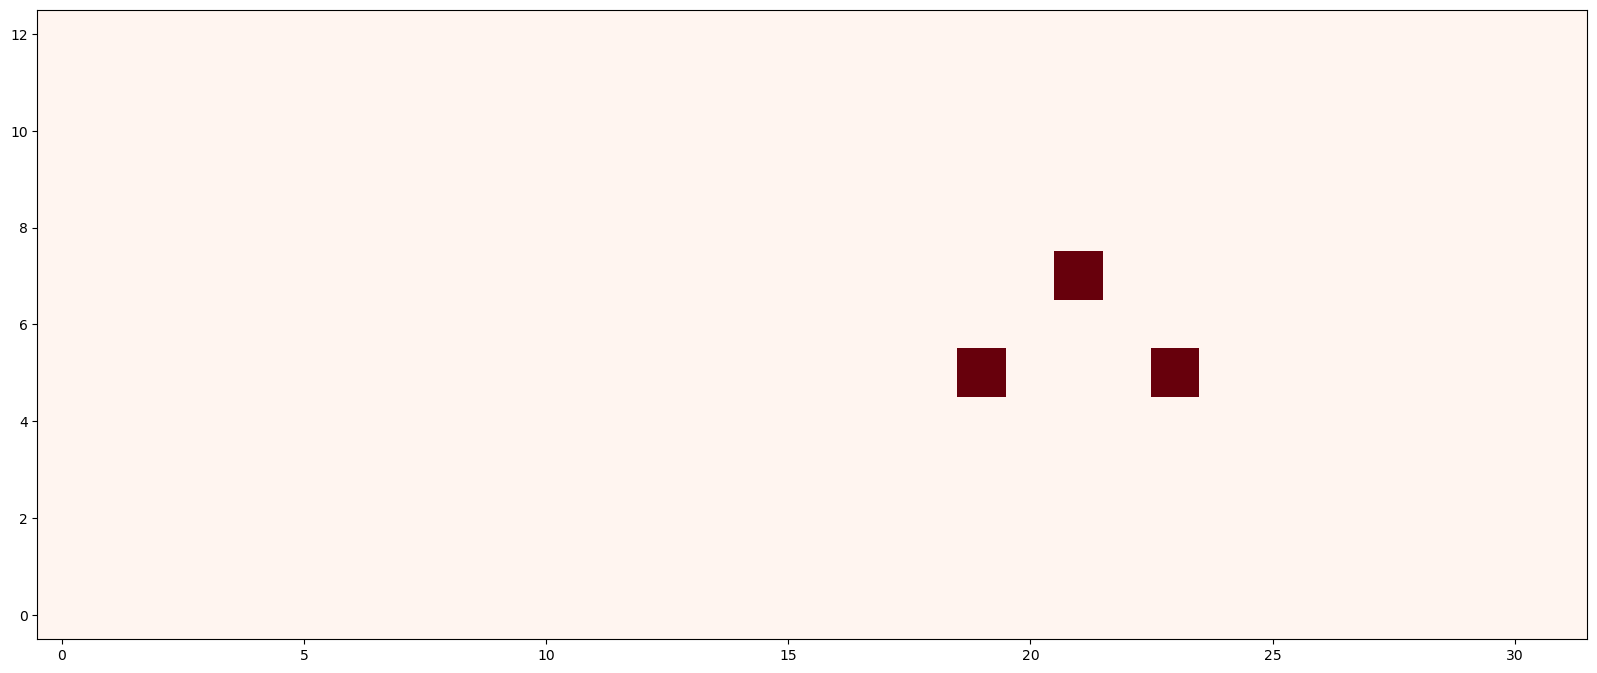

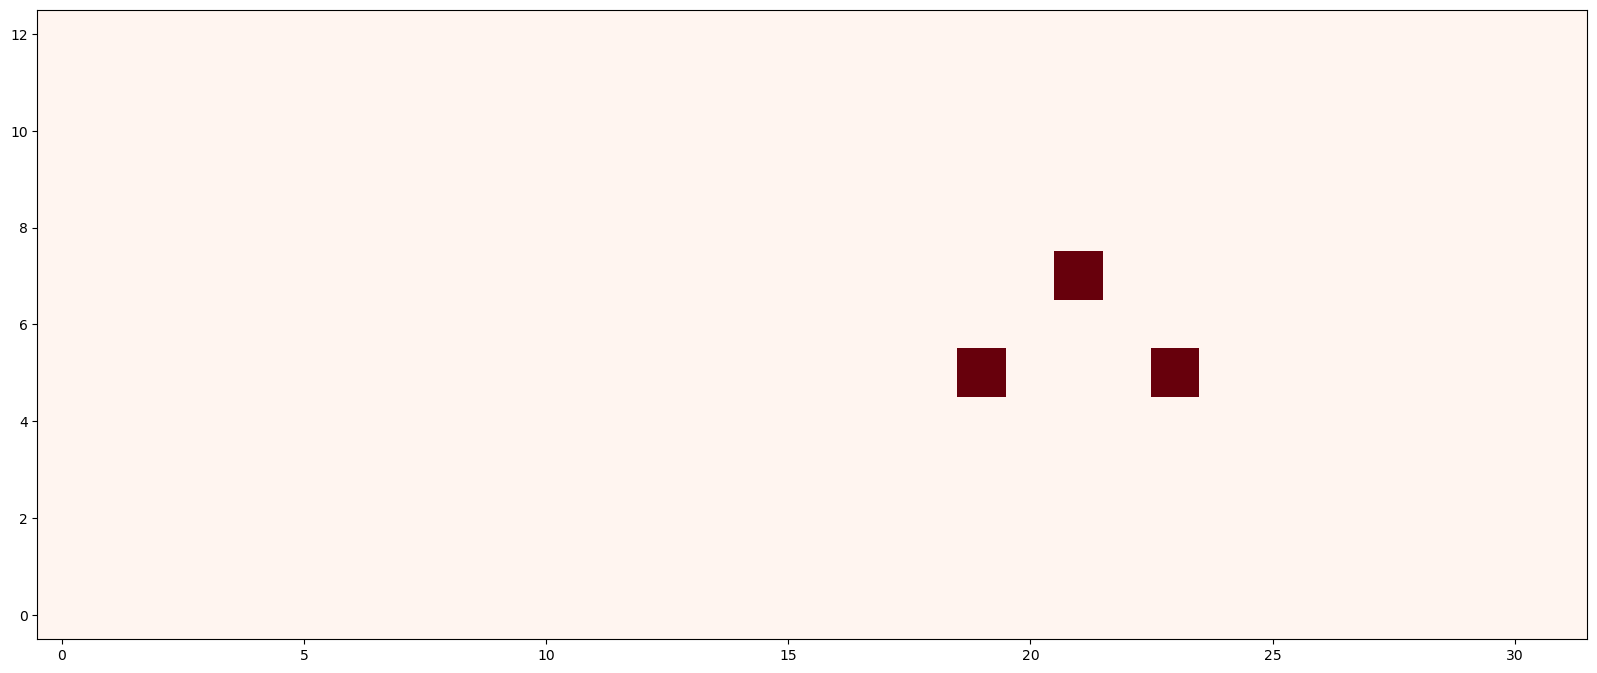

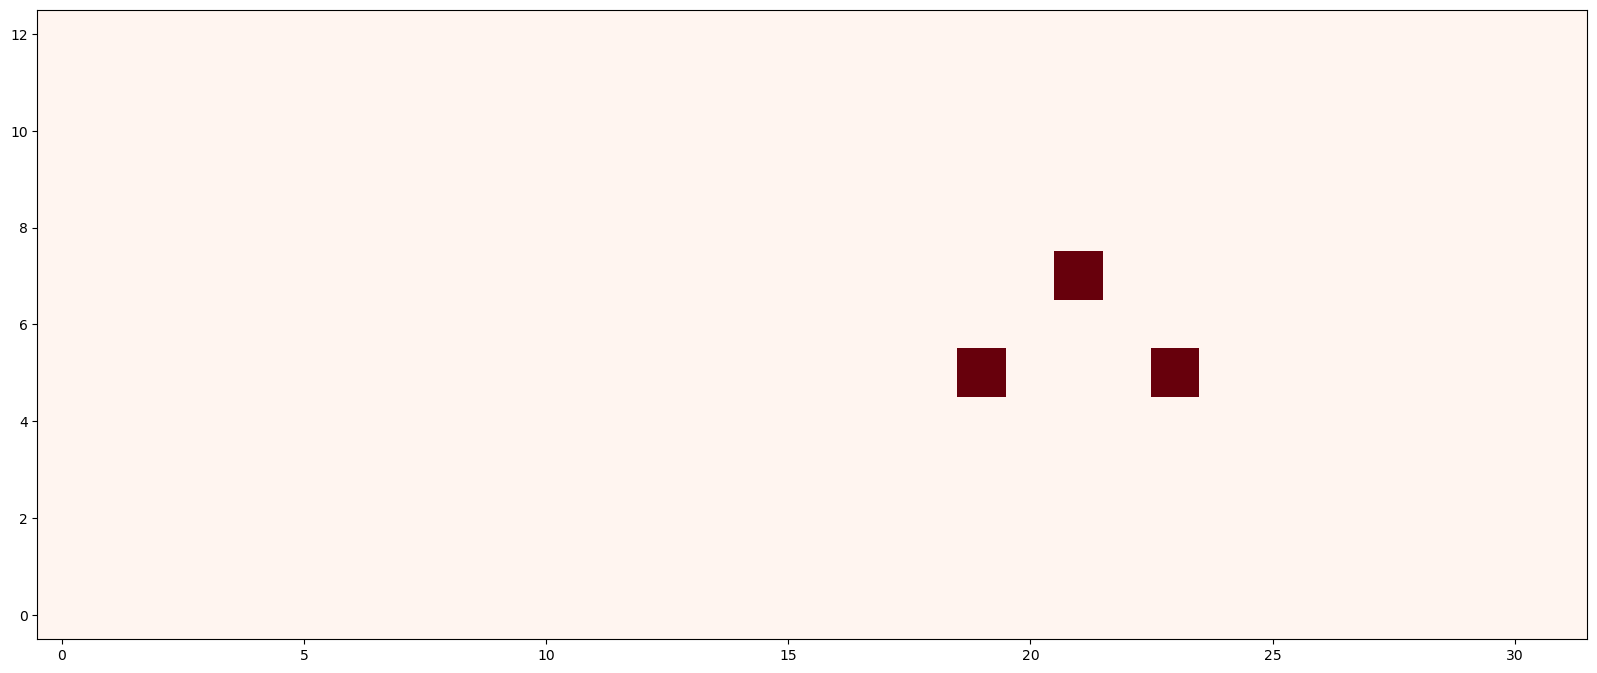

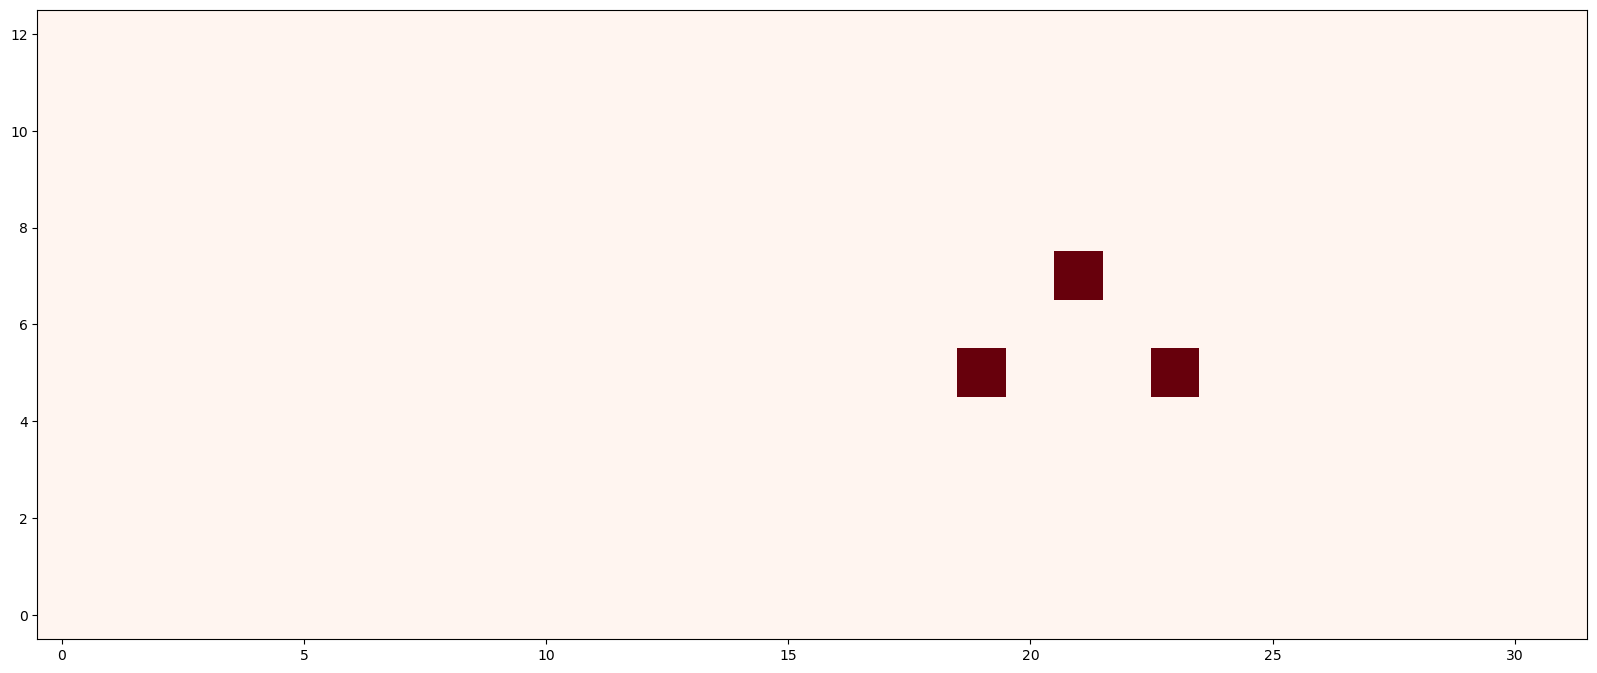

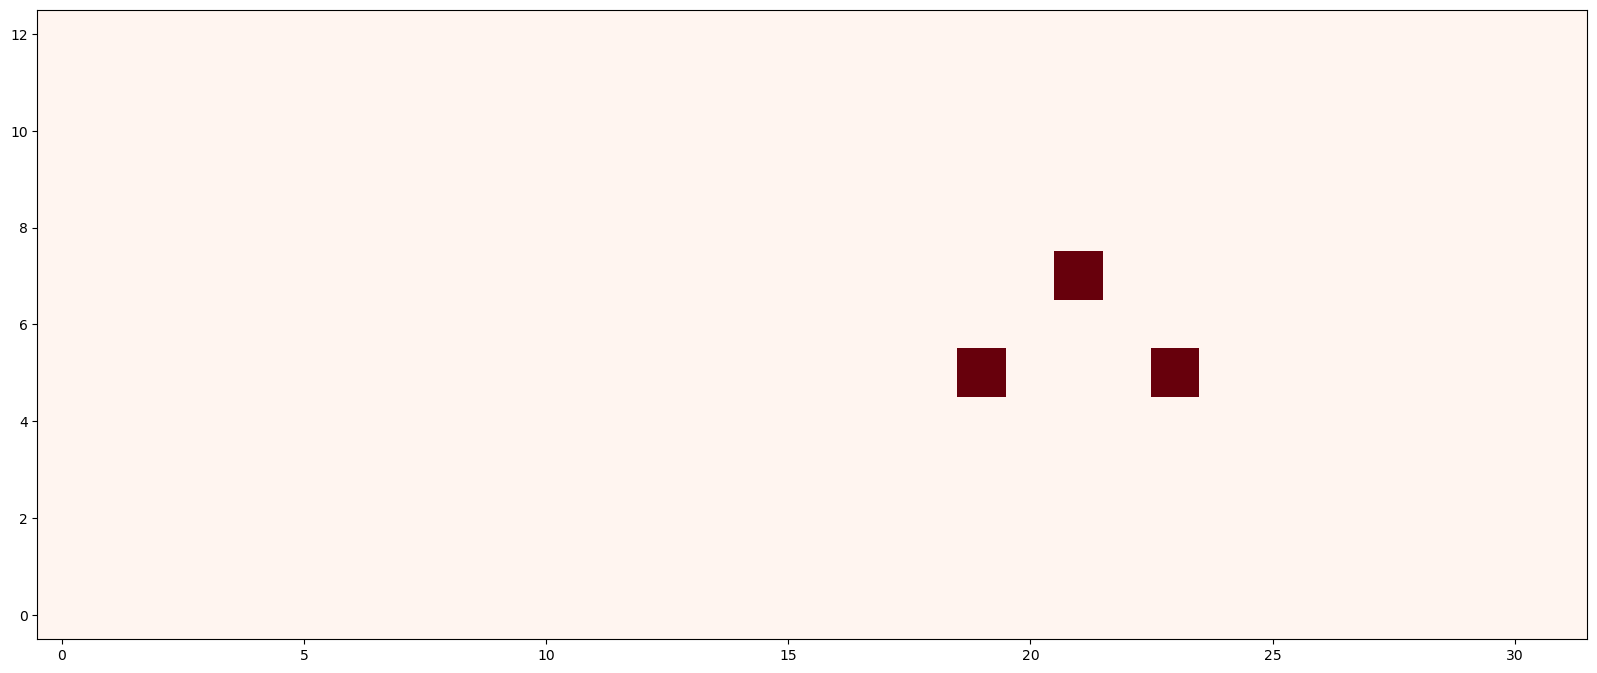

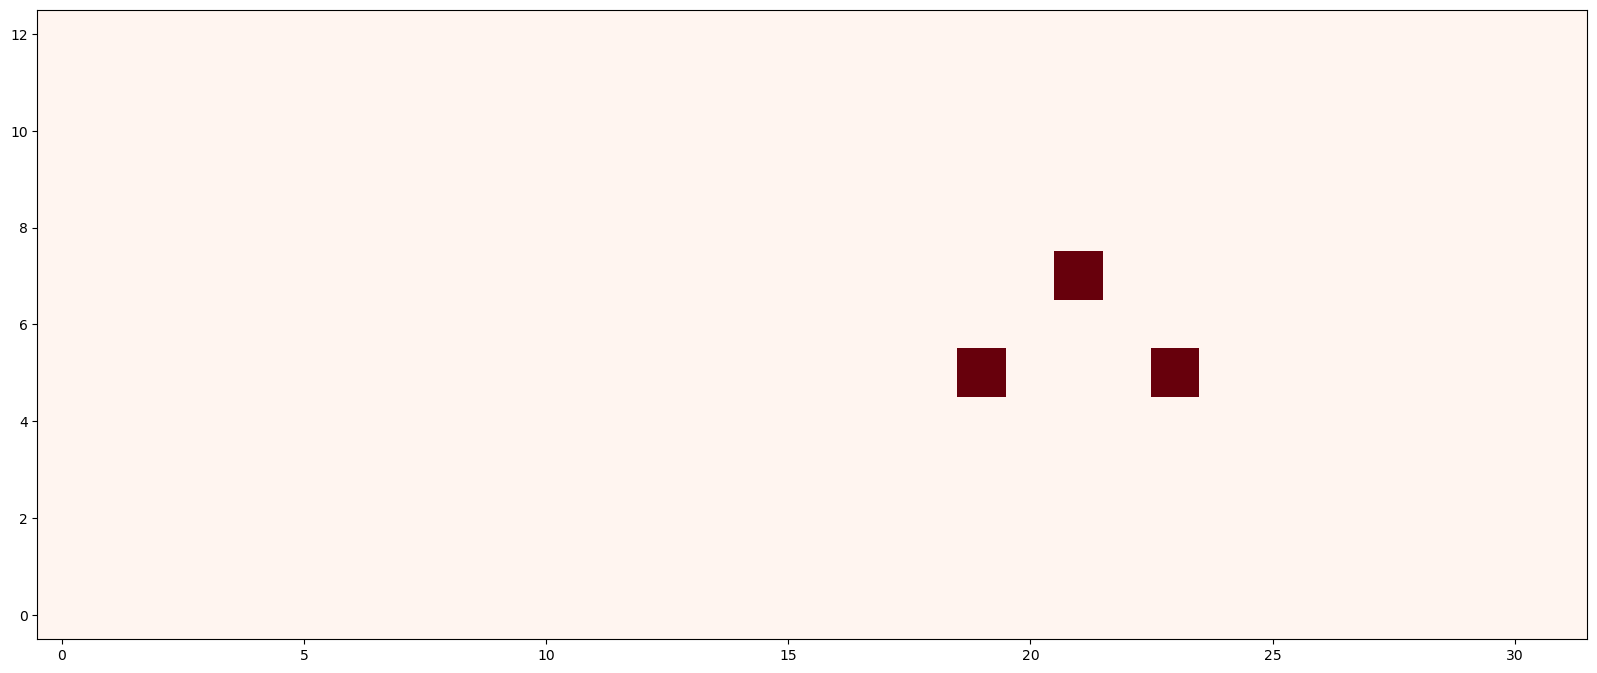

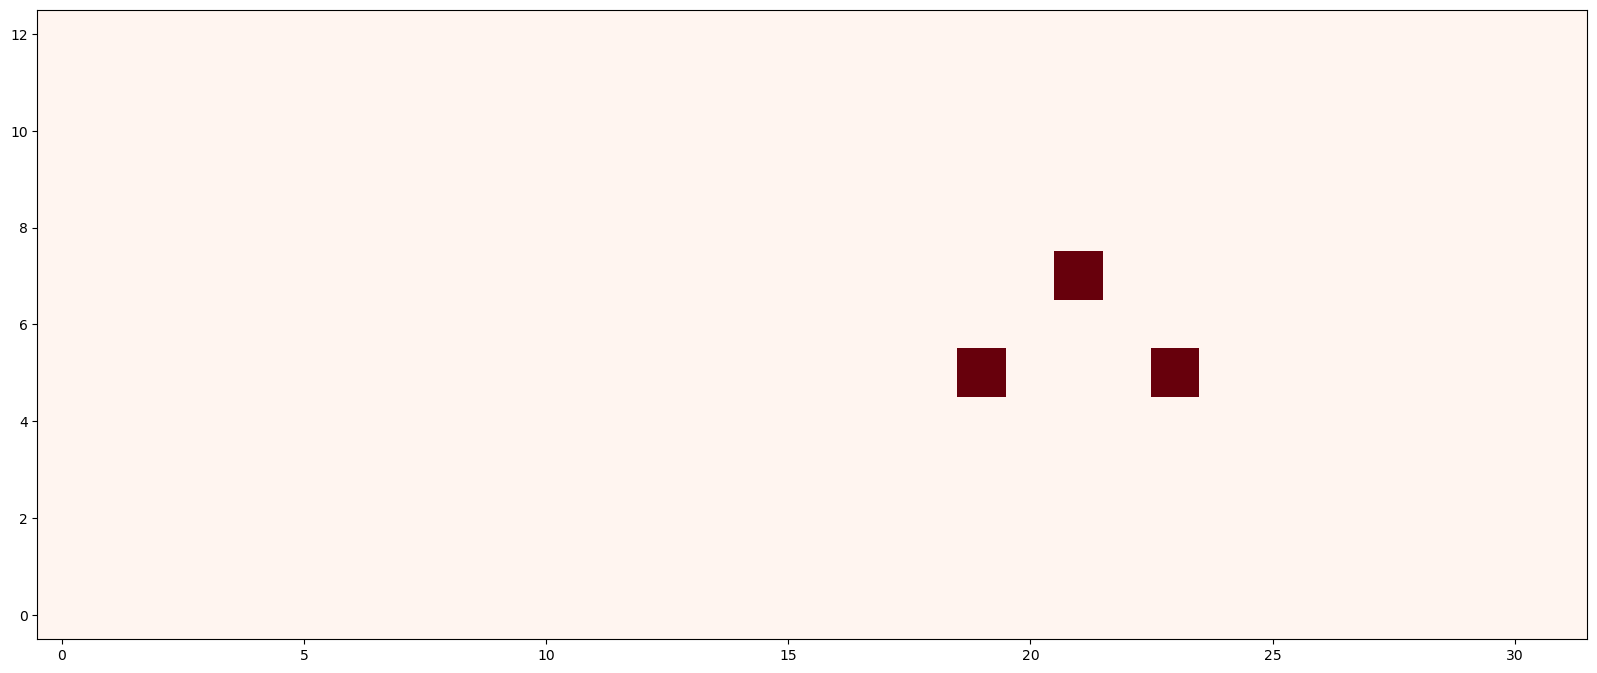

In [12]:
model.eval()
with torch.no_grad():
    training_sample = next(iter(train_loader))
    print(training_sample.shape)
    training_sample_output = model(training_sample.float().to(device))
    print(training_sample_output.shape)

    for i in range(len(training_sample)):
        plot_correlation(training_sample_output[i,0])

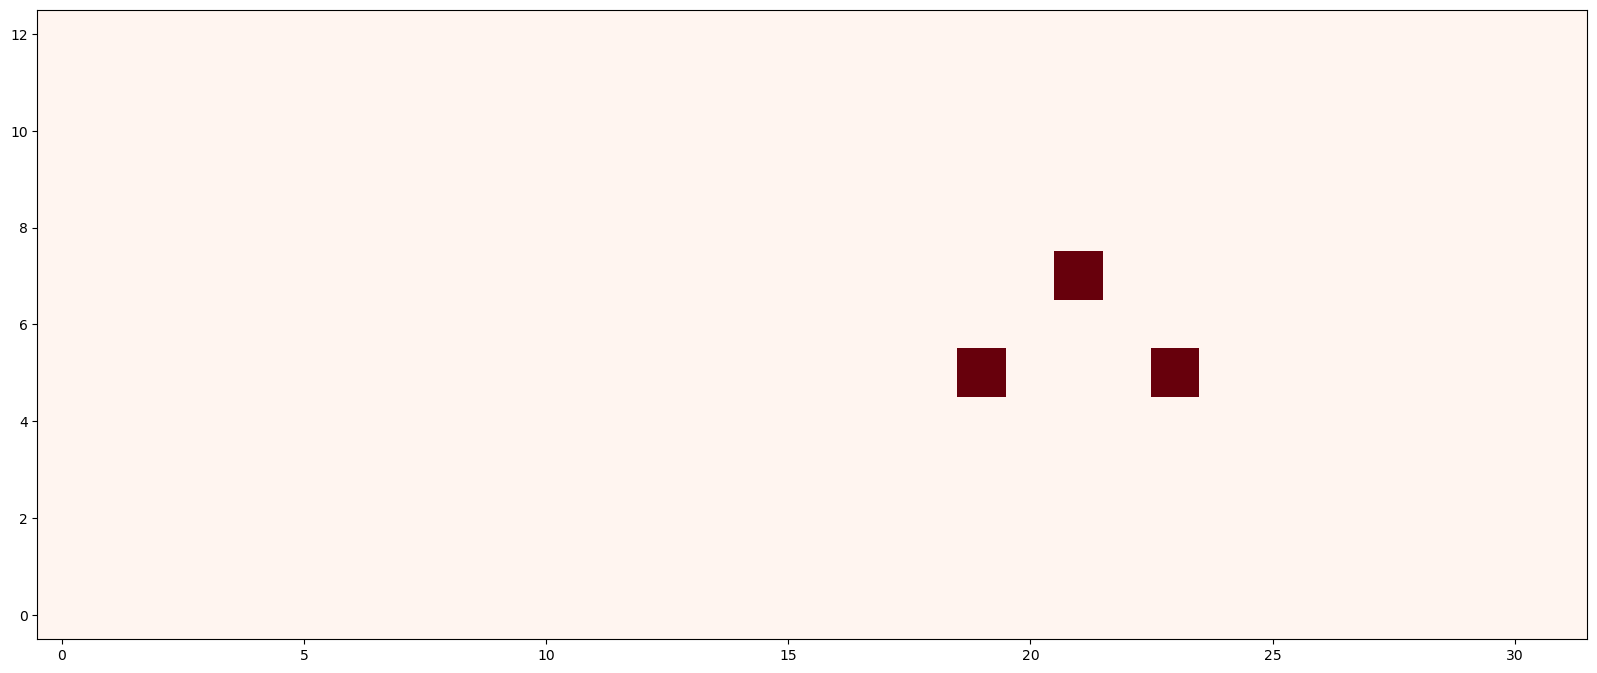

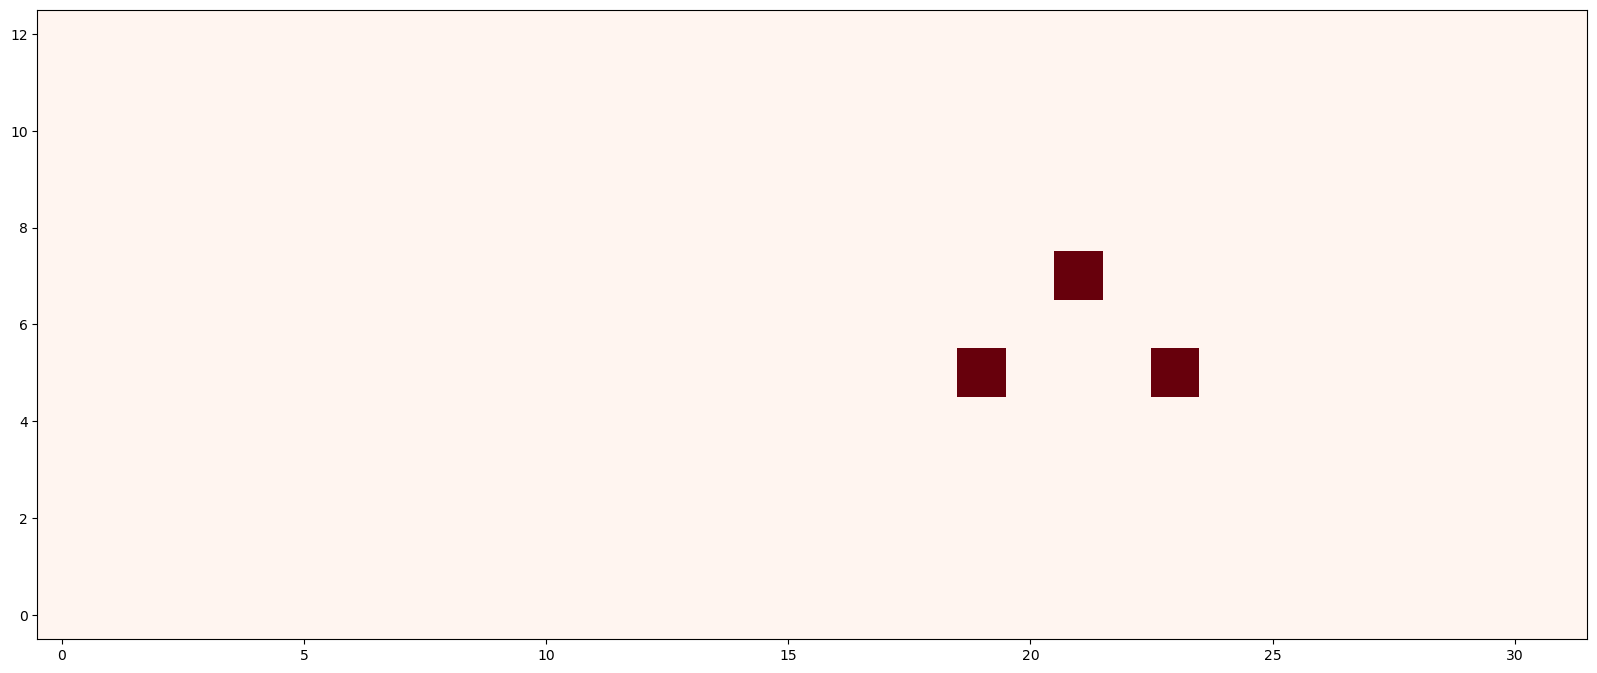

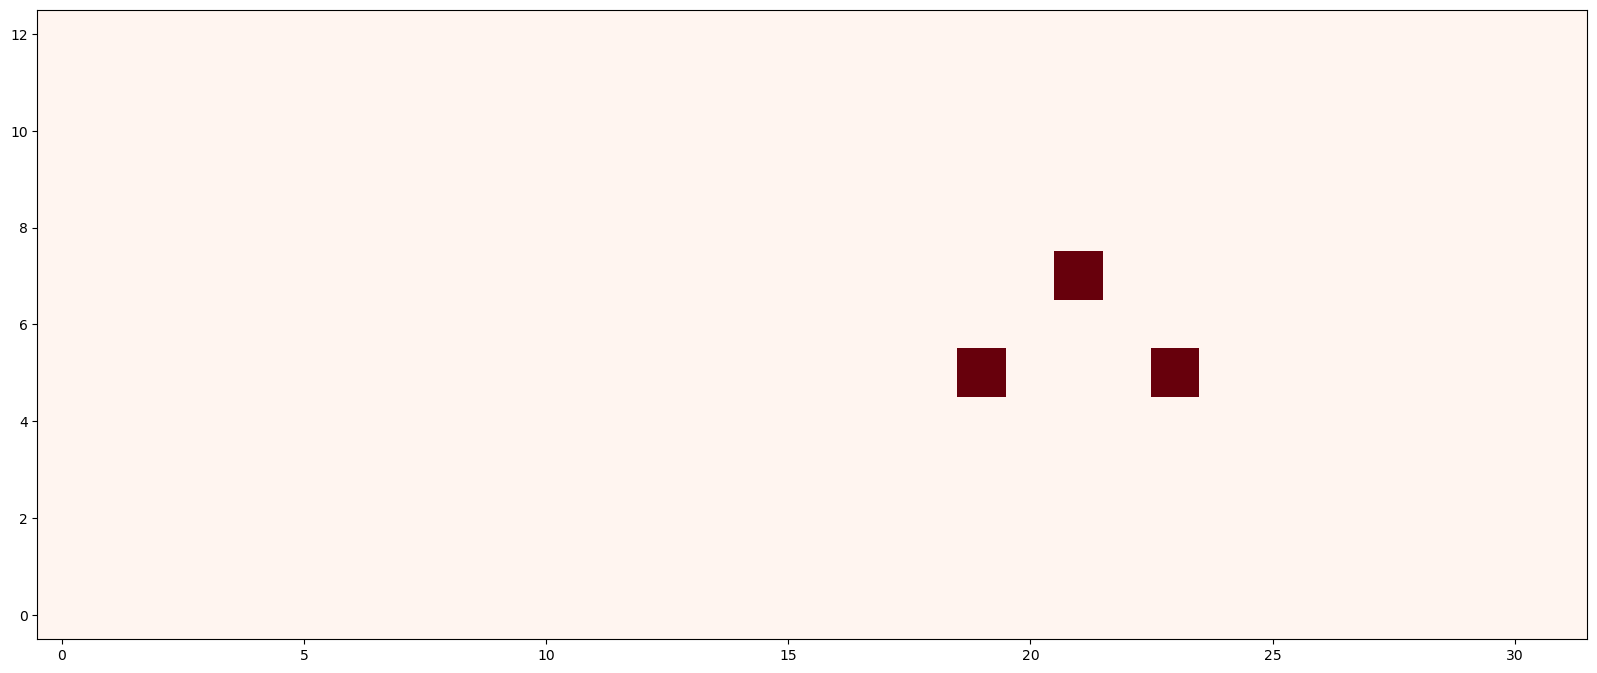

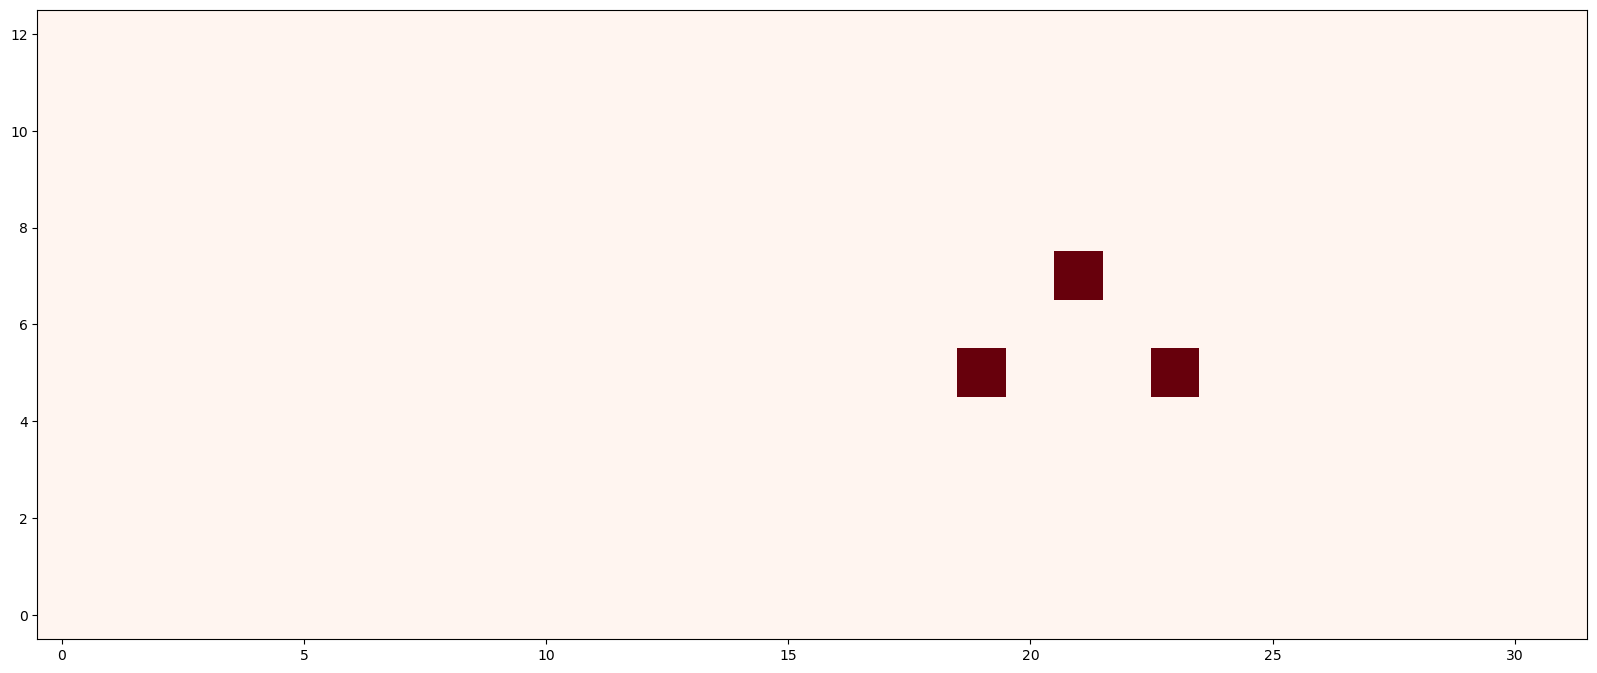

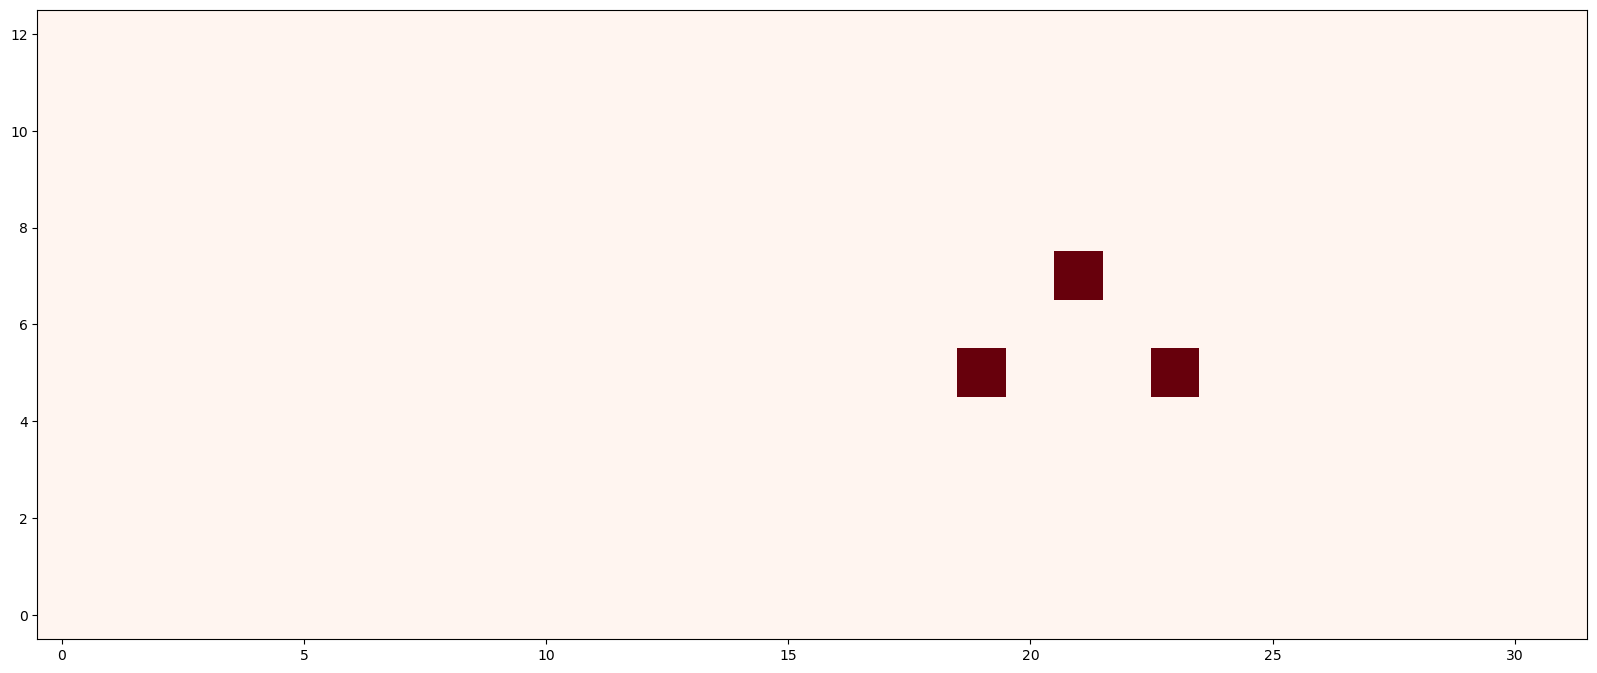

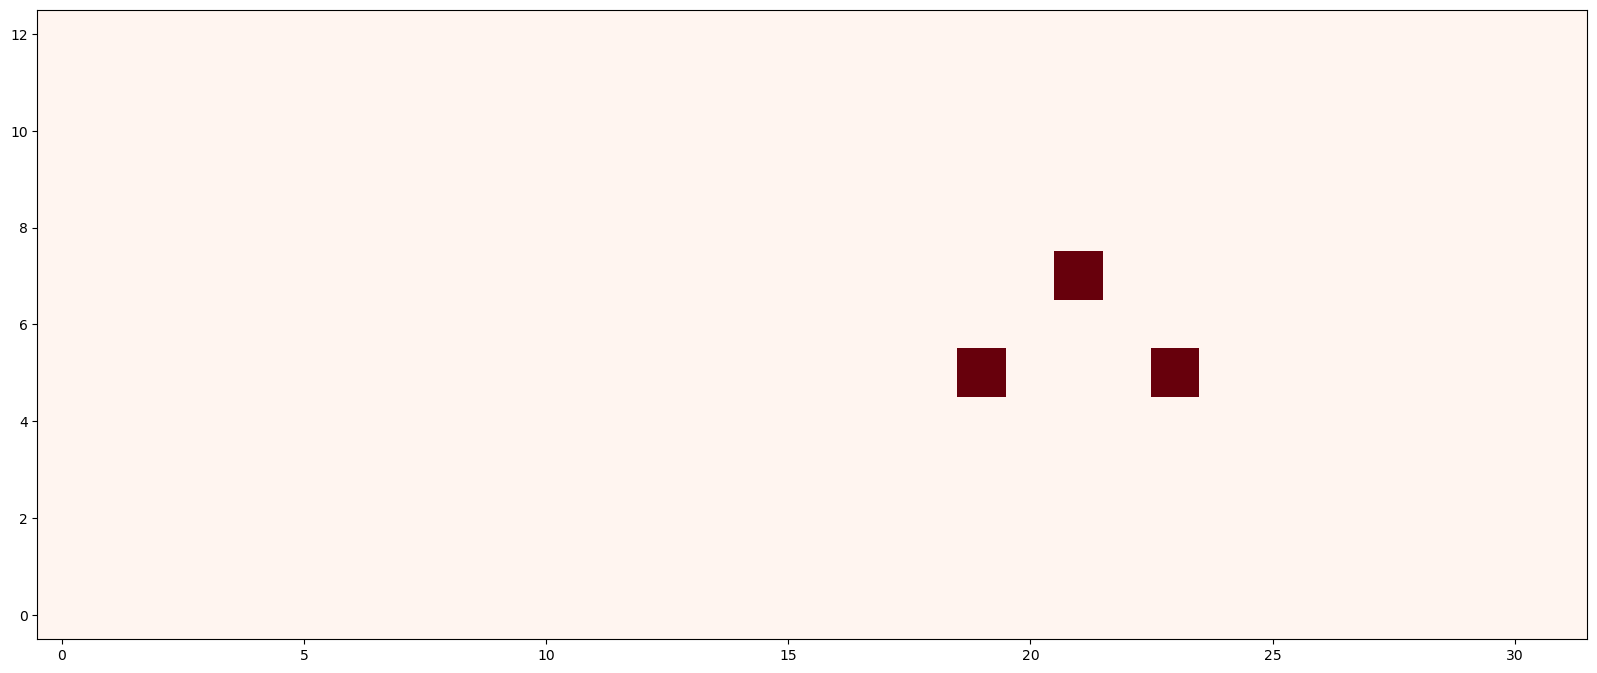

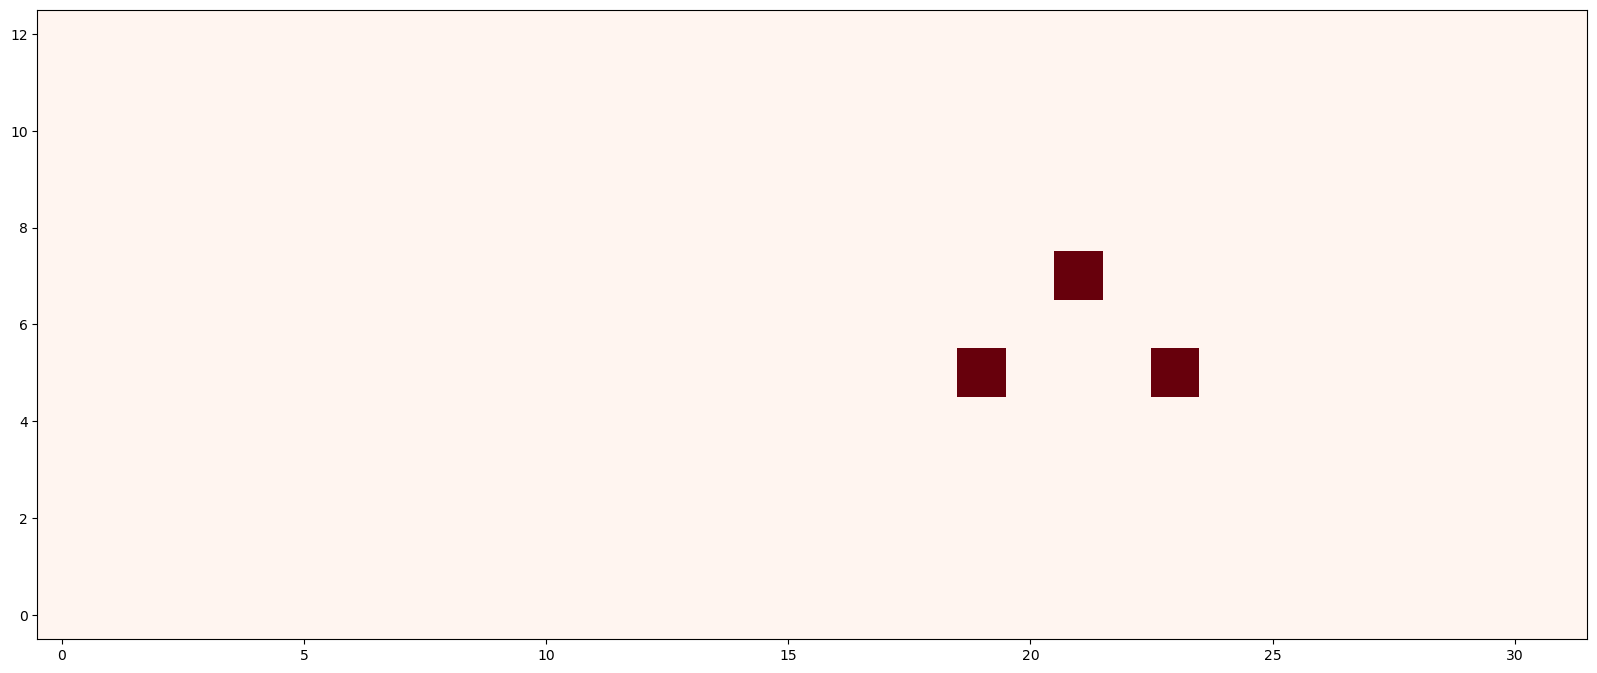

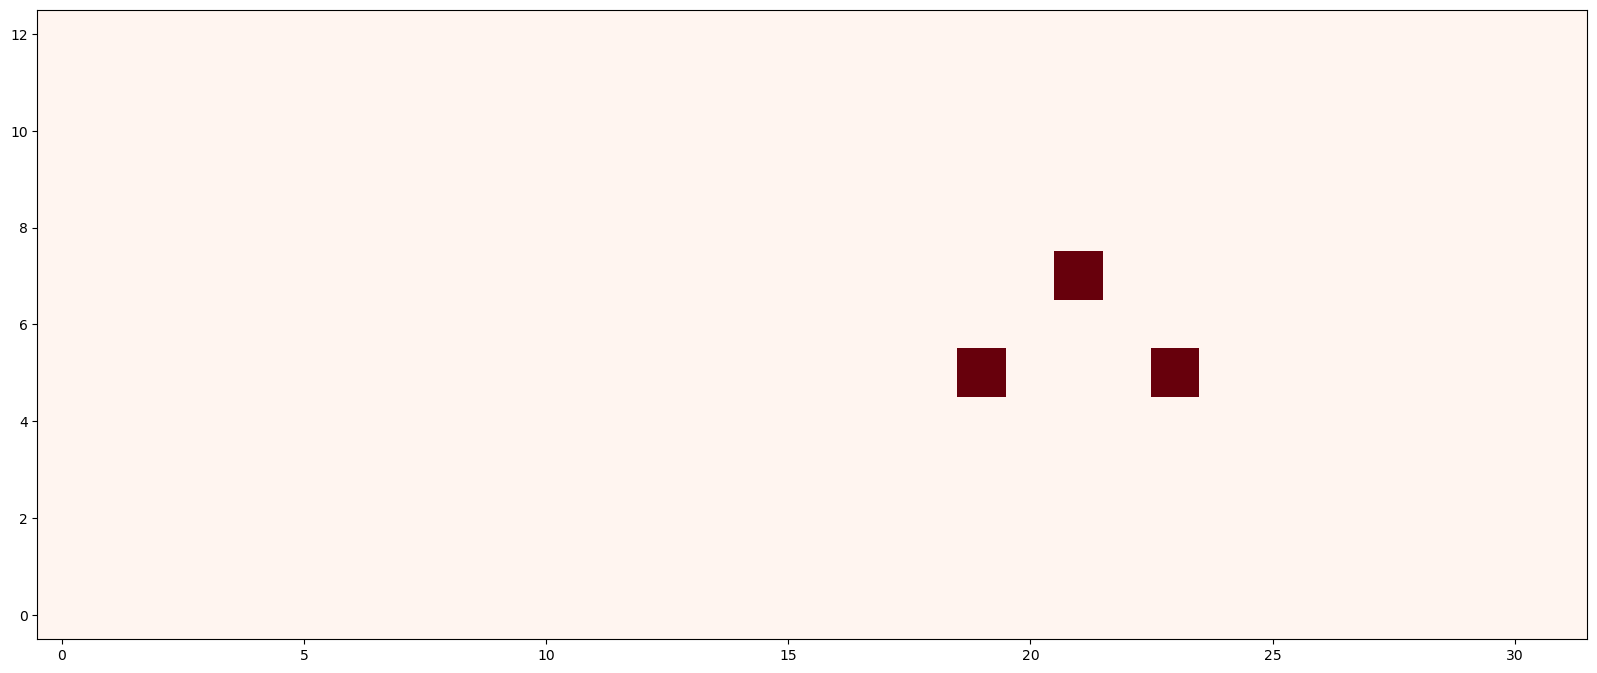

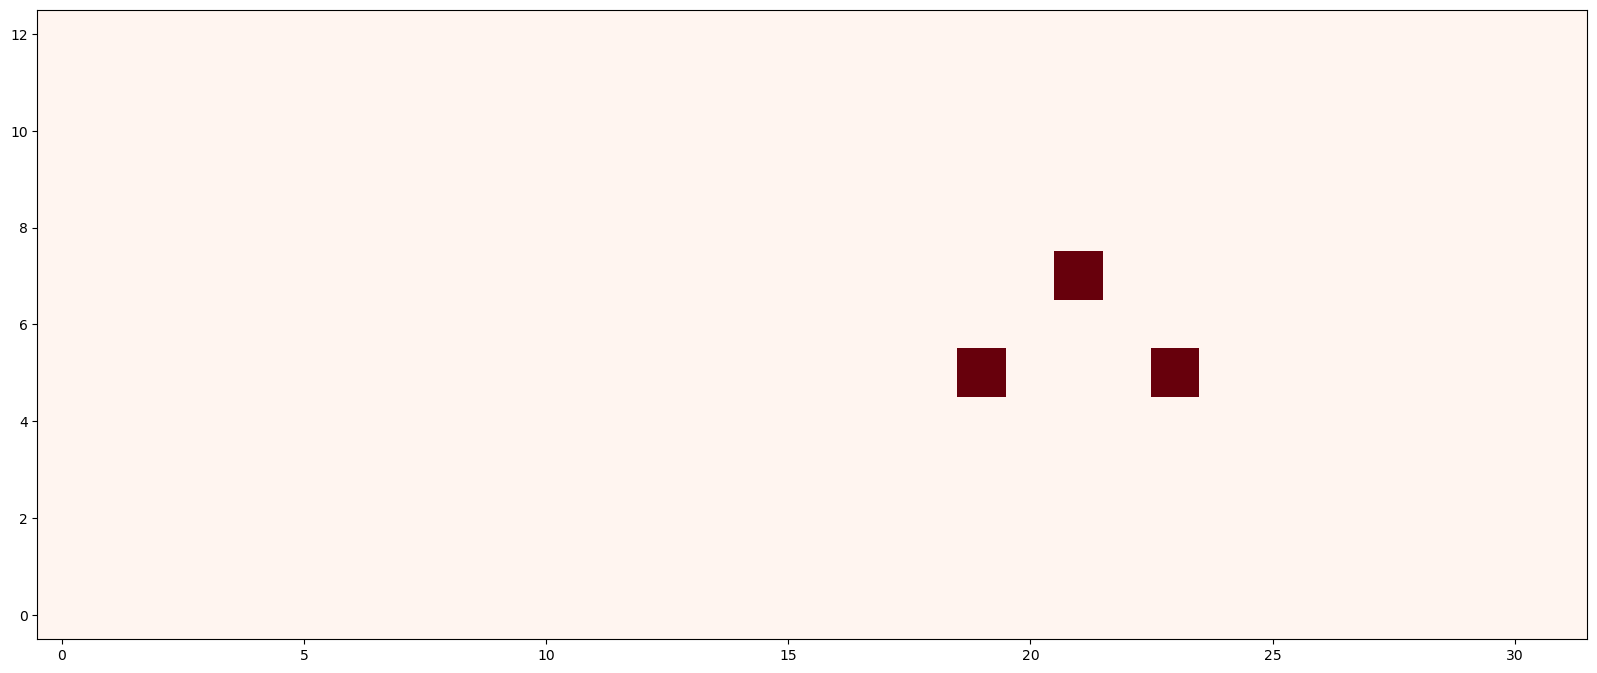

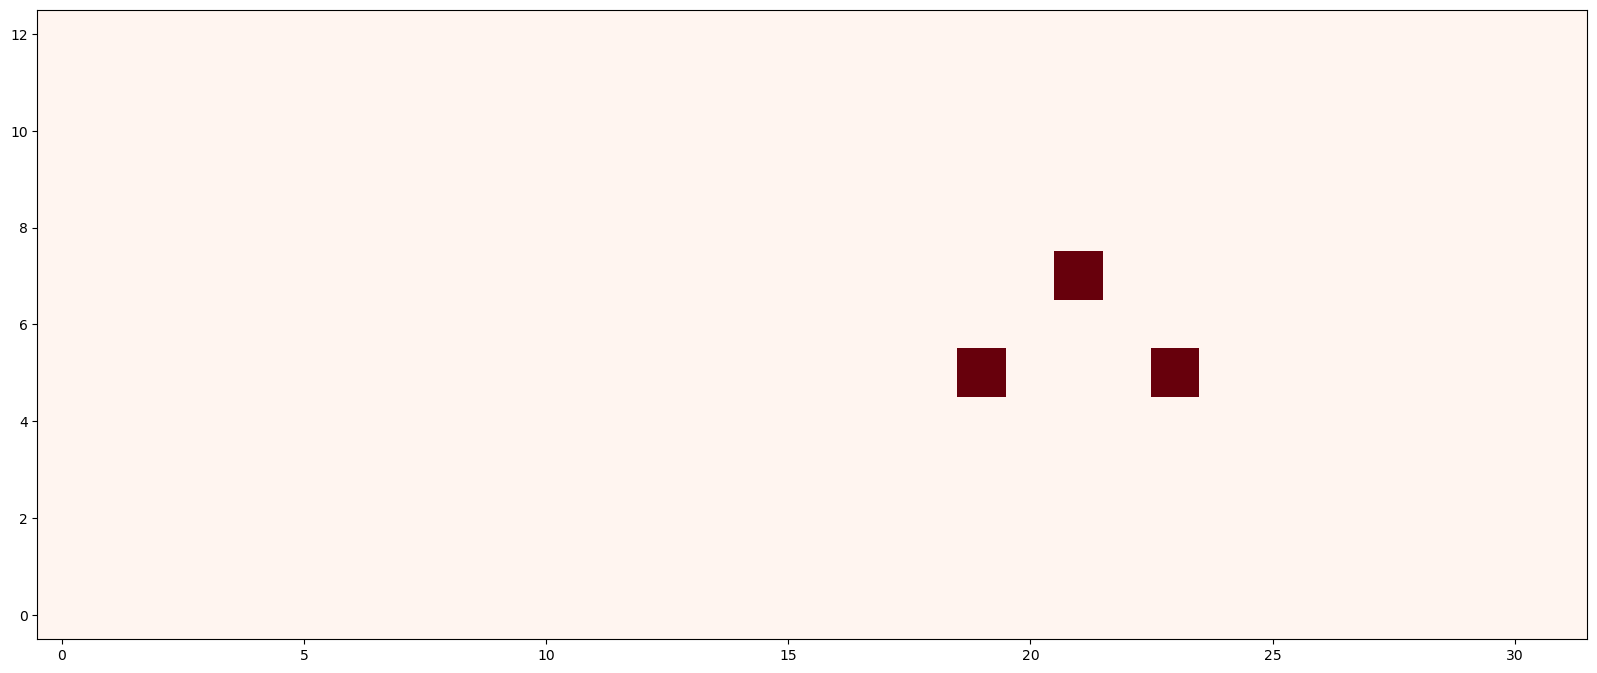

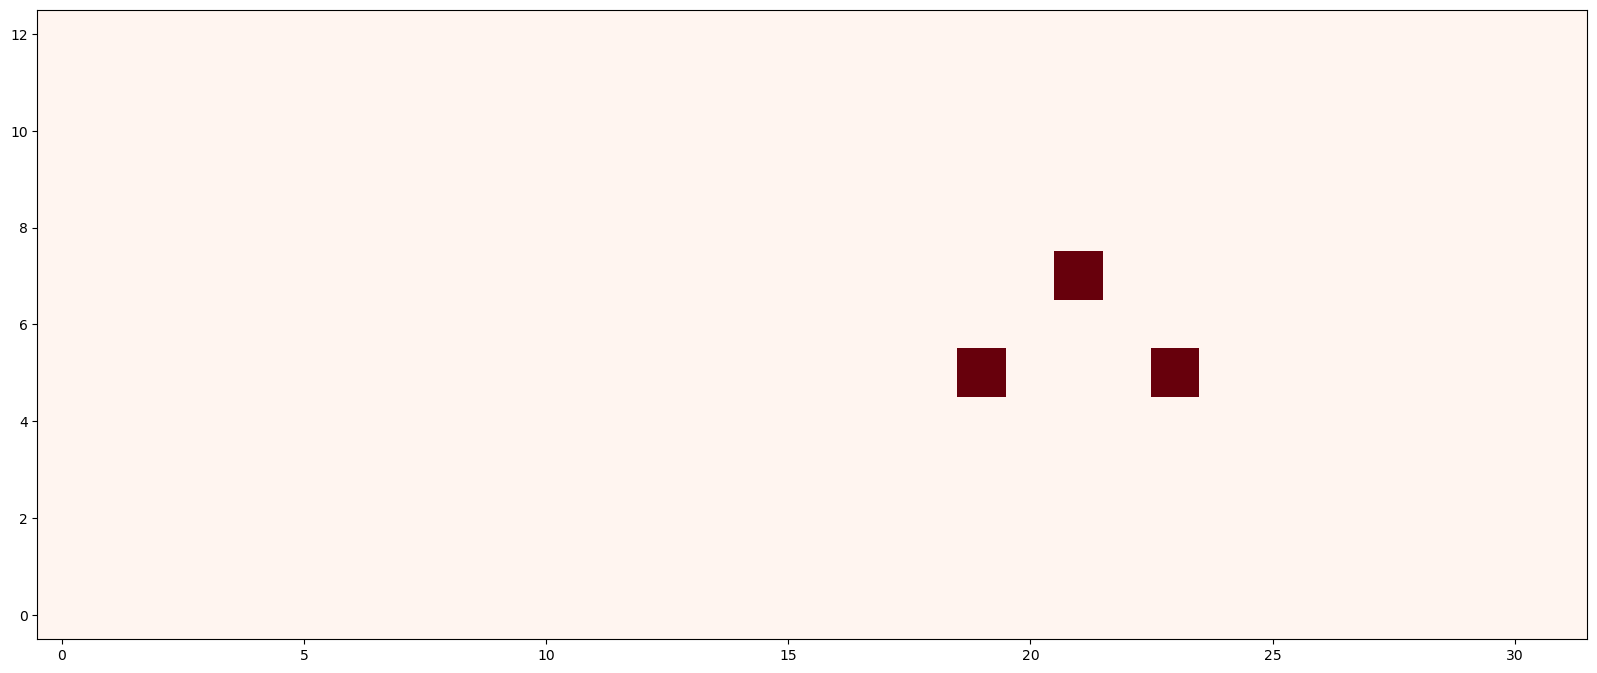

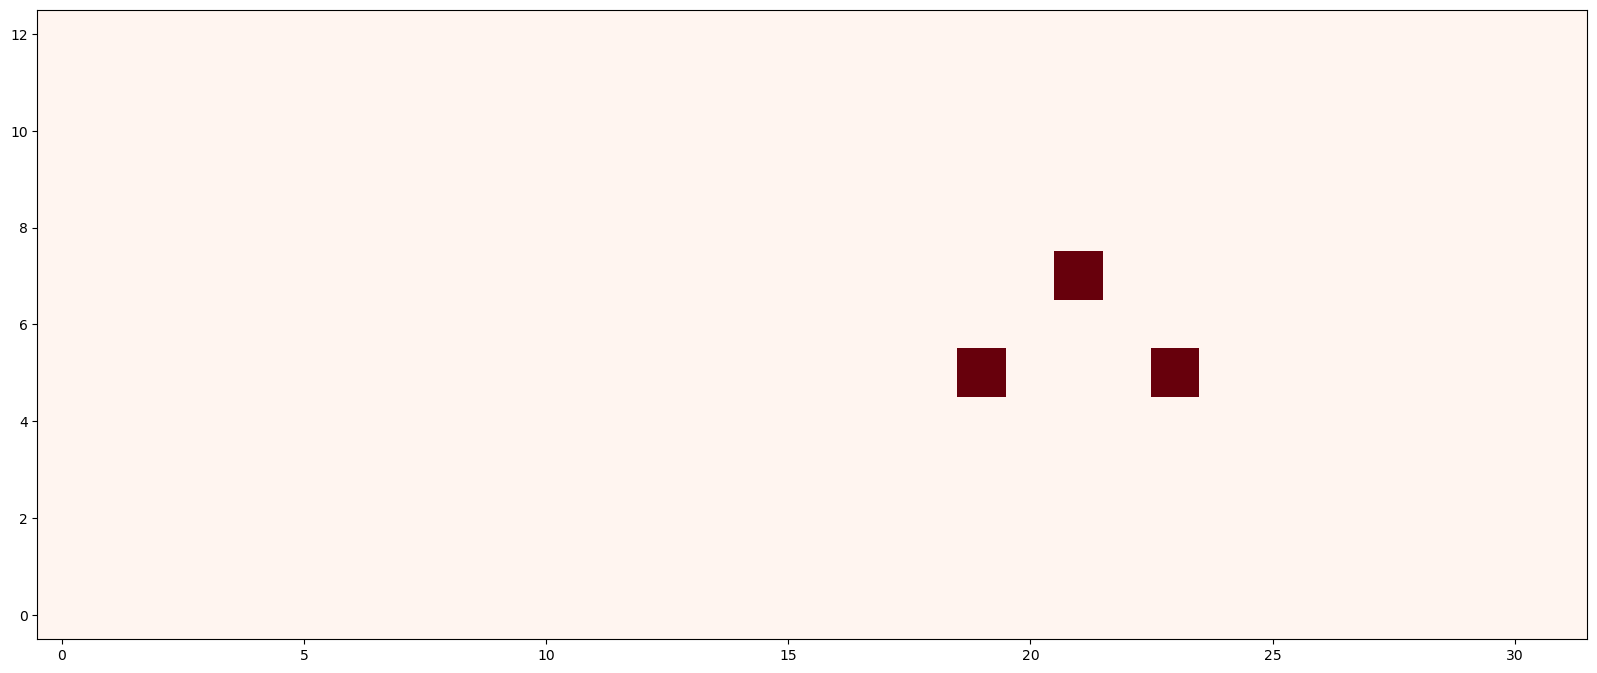

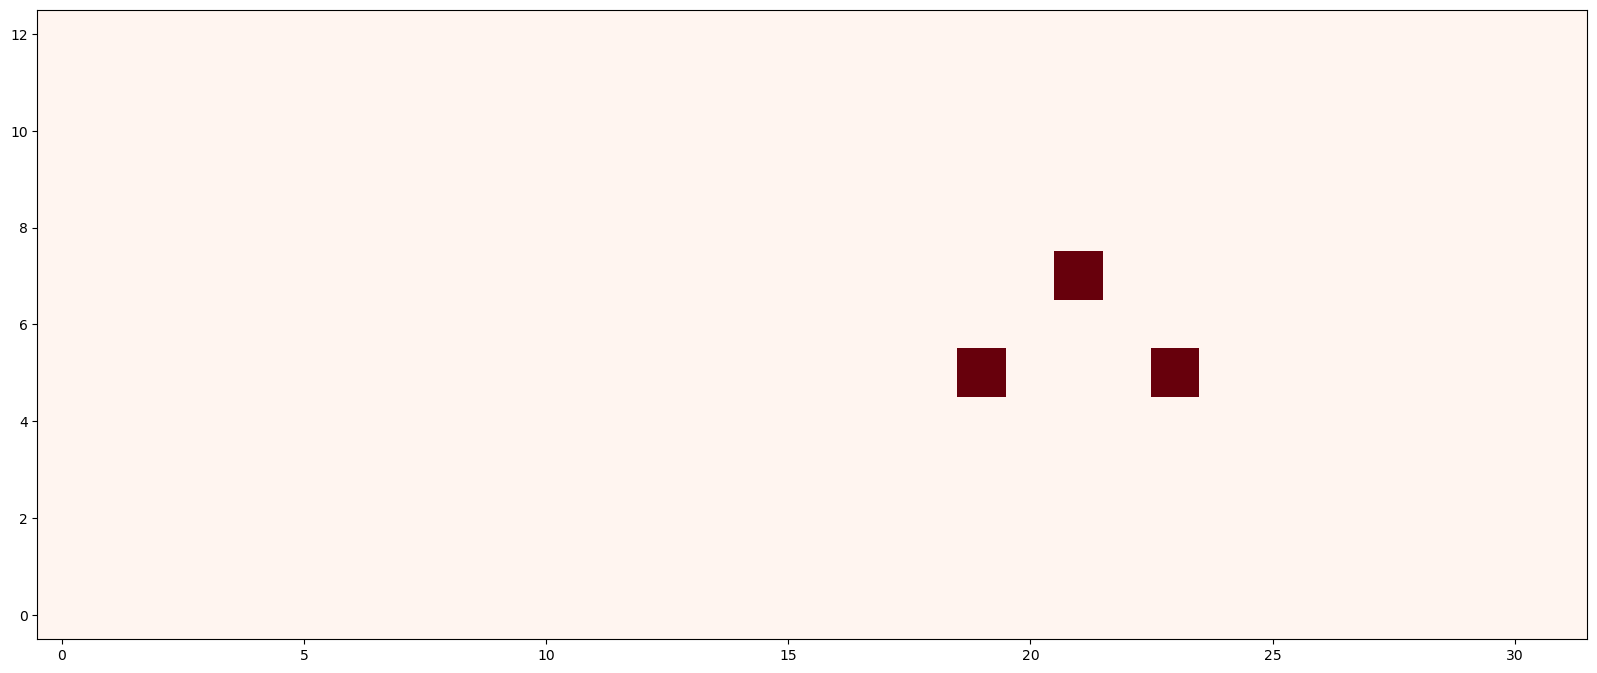

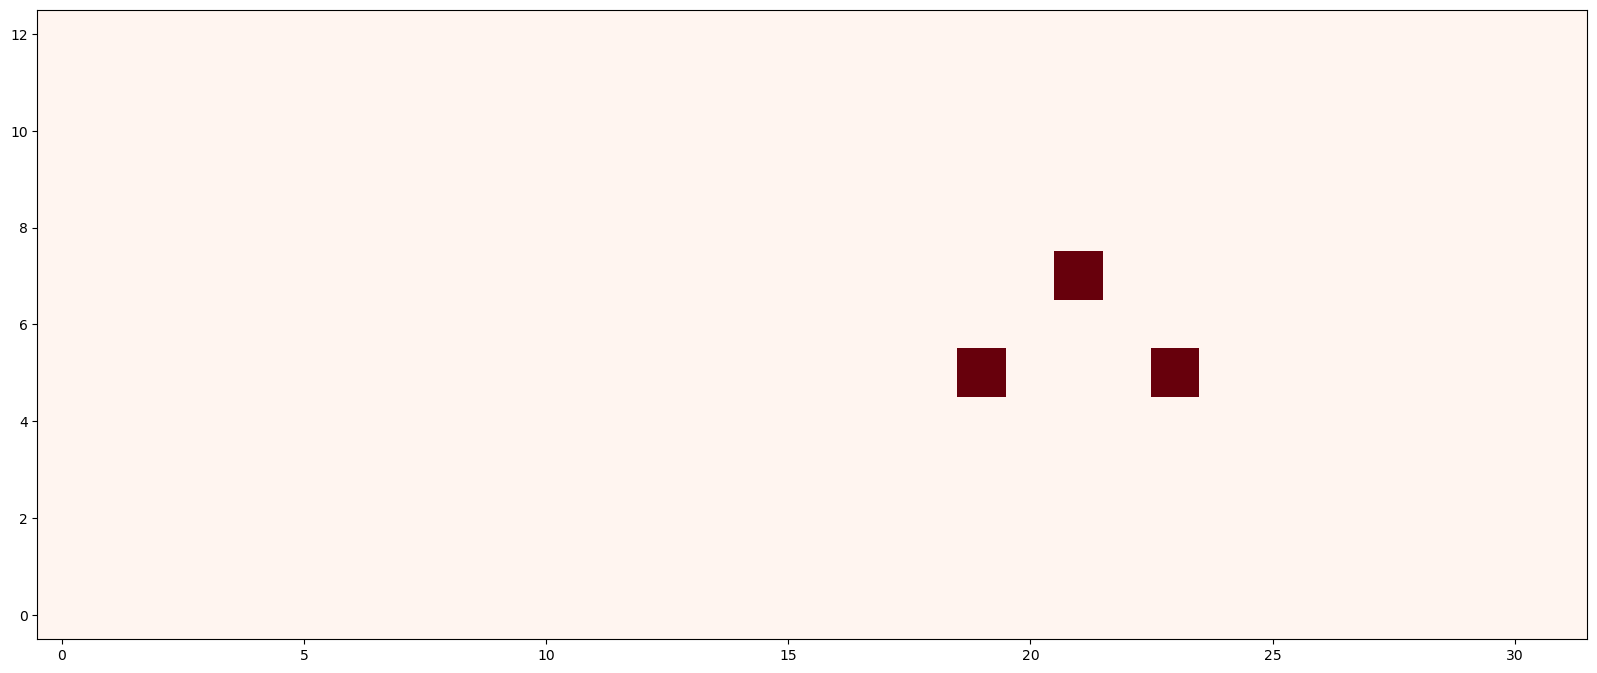

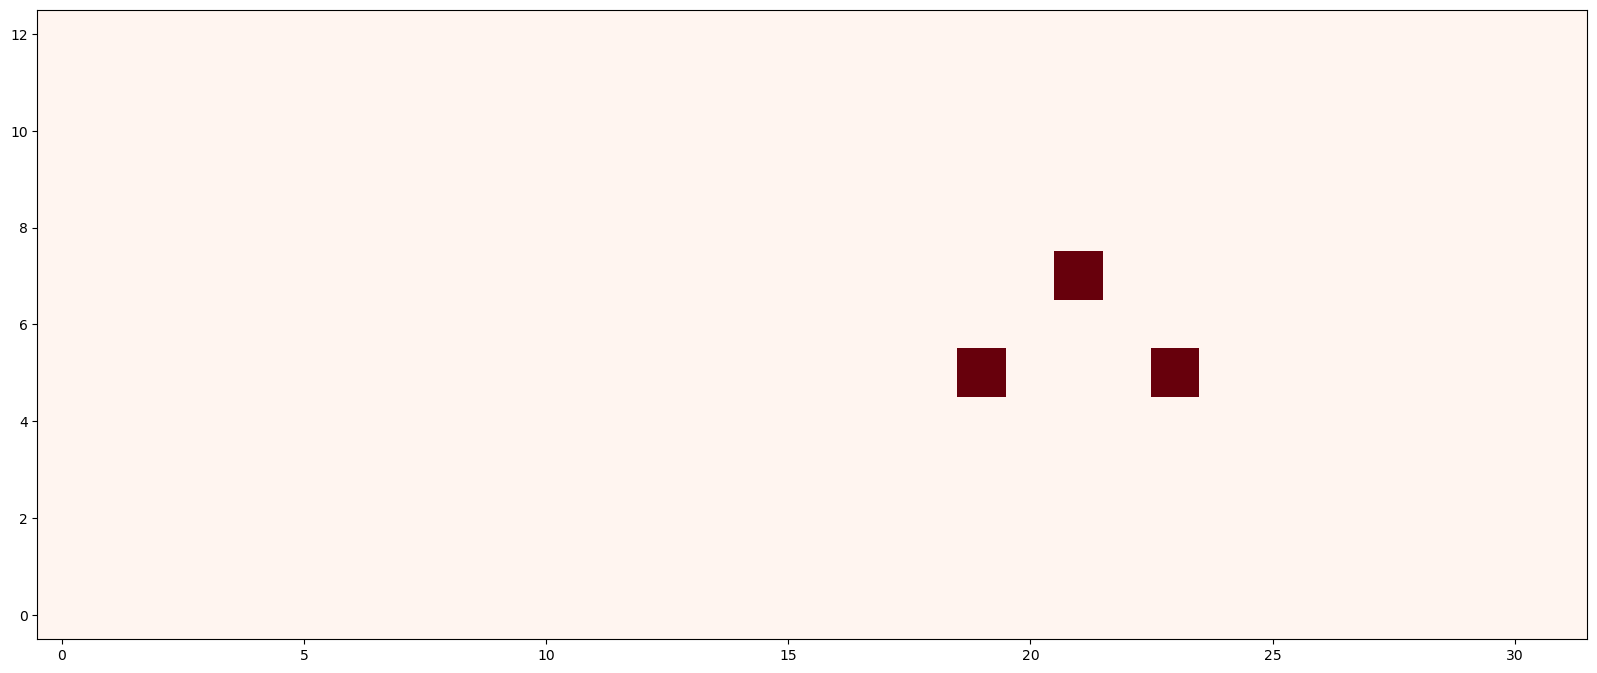

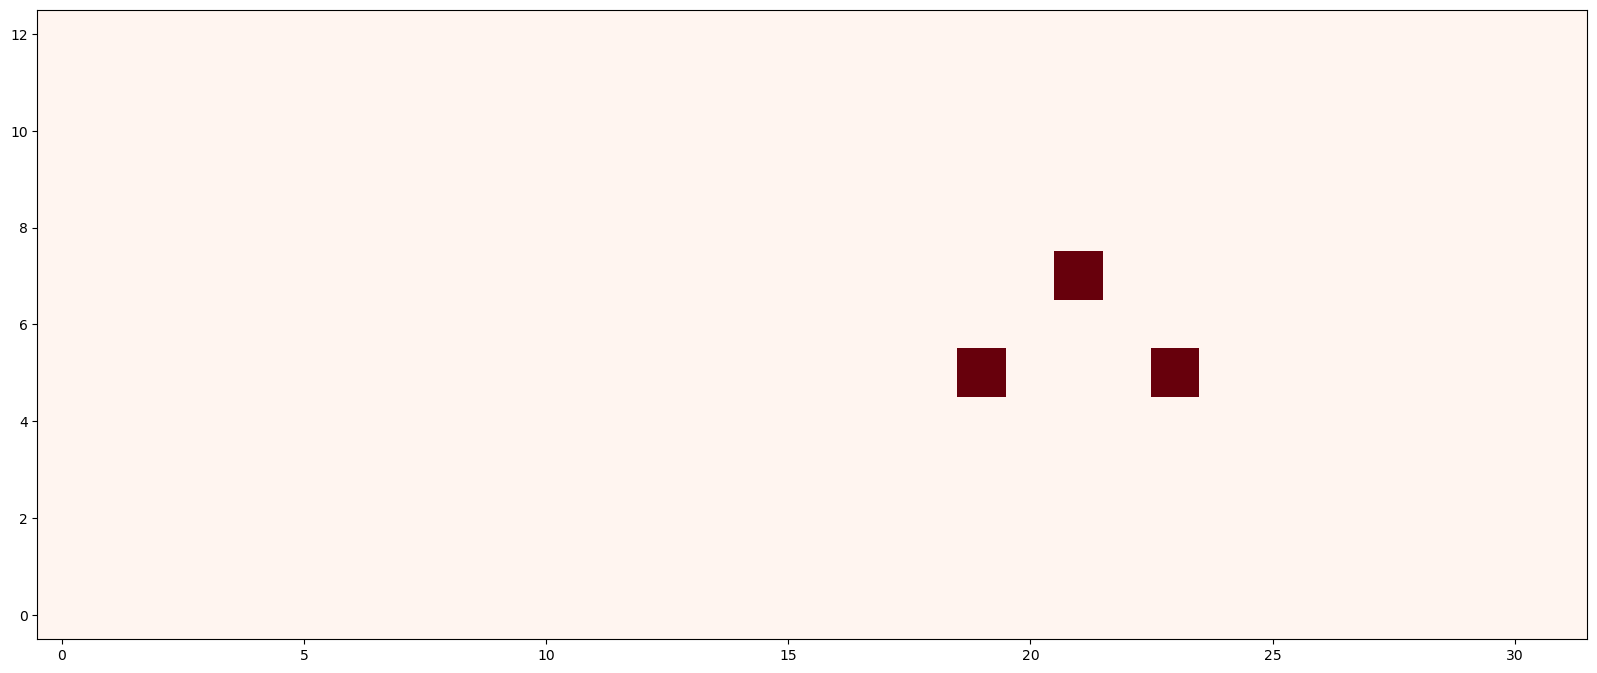

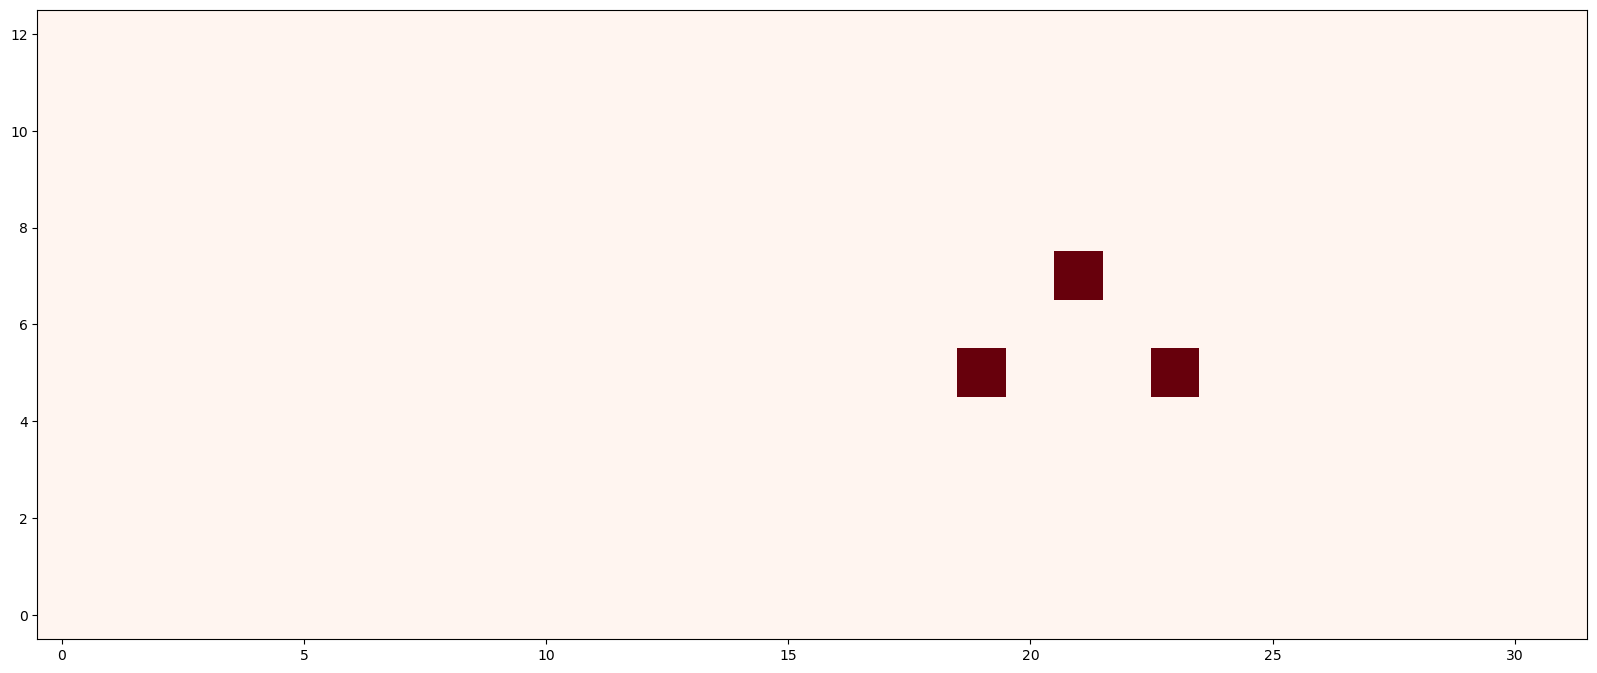

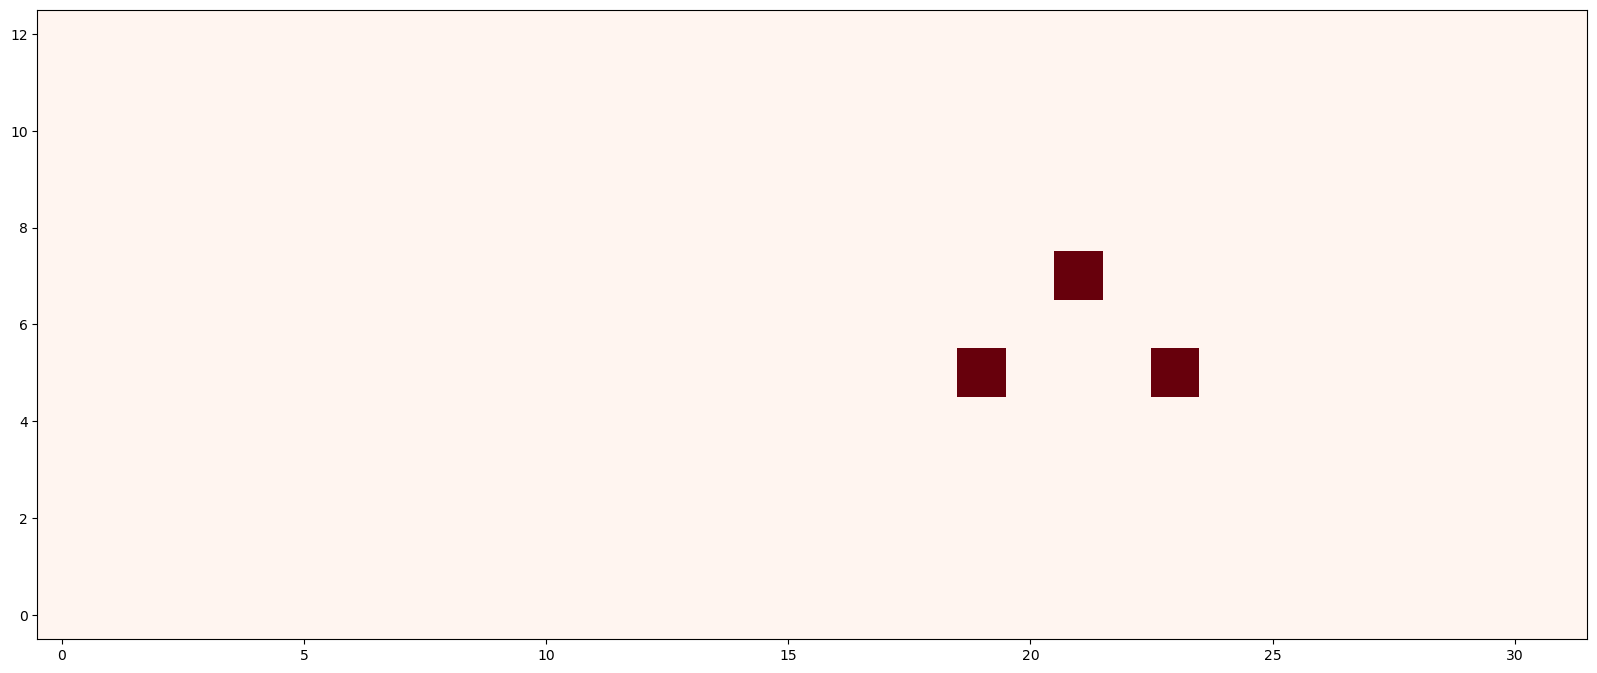

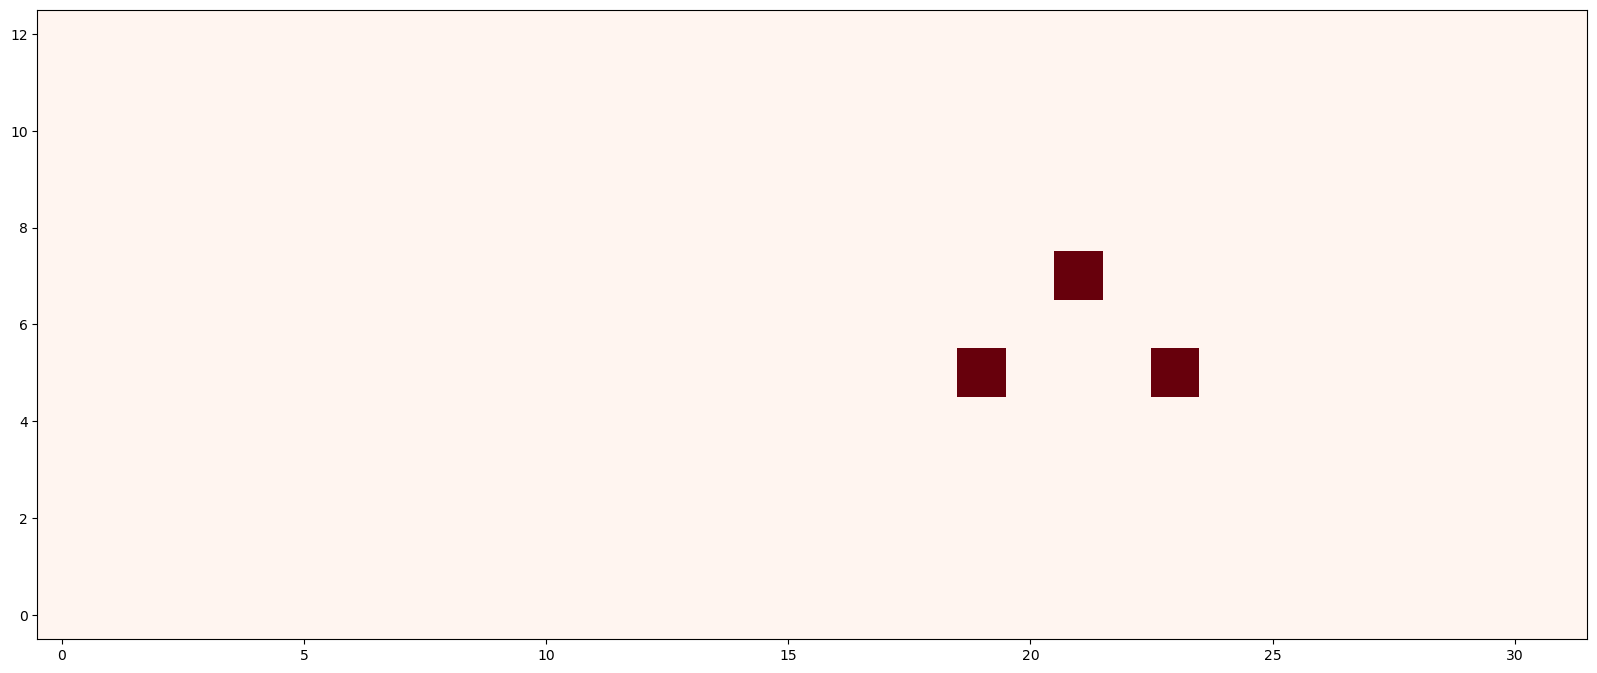

In [13]:
model.eval()
with torch.no_grad():
    test_data_output = model(test_data.float().to(device))

    for i in range(len(test_data)):
        plot_correlation(test_data_output[i,0])